In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

In [26]:
hyb = lumapi.FDTD(filename='Bend90Hybrid.fsp',hide=False) 

## Functions

In [27]:
# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

In [31]:
hyb.switchtolayout()
hyb.deleteall()

hyb.addobject('90_bend_wg')
hyb.set({"base angle":90, "base height":0.22e-6, "base width":0.5e-6,
         "radius":4e-6, "material":"Si (Silicon) - Palik"})
hyb.set({"start angle":0, "name":"Output bend 1",
        "x":0, "y":0, "z":0})

RectInsert(4e-6, 0.5e-6, -1e-6, 2e-6, 0, 0.22e-6, "Si (Silicon) - Palik", hyb)
hyb.set("name","Input waveguide")
RectInsert(-1e-6, 2e-6, 4e-6, 0.5e-6, 0, 0.22e-6, "Si (Silicon) - Palik", hyb)
hyb.set("name","Output waveguide")


# FDTD Setting
hyb.addfdtd()
hyb.set({"x":2e-6, "y":2e-6, "z":0, "z span":3e-6,
         "simulation time":1000e-15, "mesh accuracy":4})
hyb.set({"x span":7.5e-6, "y span": 7.5e-6})
hyb.set("background material","SiO2 (Glass) - Palik")


# Creating Ports
hyb.addport()
hyb.set({"x":-1.5e-6, "y":4e-6, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Forward"})

hyb.addport()
hyb.set("injection axis","y-axis")
hyb.set({"x":4e-6, "y": -1.5e-6, "z":0,
        "x span":3e-6, "z span":3e-6,
        "direction":"Forward"})

# Editing source settings
hyb.select('FDTD::ports')
hyb.set('monitor frequency points',1500)
hyb.setglobalsource("wavelength start", 1500e-9)
hyb.setglobalsource("wavelength stop", 1600e-9)


# Creating monitor region
hyb.addpower()  # Planar monitor
hyb.set({"x":2e-6, "x span":6e-6, "y":2e-6, "y span":6e-6})
hyb.setglobalmonitor("use source limits",0)
hyb.setglobalmonitor("minimum wavelength",1500e-9)
hyb.setglobalmonitor("maximum wavelength",1600e-9)
hyb.setglobalmonitor("frequency points",20)

1.0

## Mesh convergence sweep

In [32]:
# Sweep configs
SPoints = 6      # Sweep points
SRange = [2,7]  # Sweep range
Name = "Mesh_sweep"

# Sweep creation
hyb.deletesweep(Name)
hyb.addsweep(0)
hyb.setsweep("sweep","name",Name)
hyb.setsweep(Name,"type","Ranges")
hyb.setsweep(Name,"number of points",SPoints)

MeshParameter = {"Name":"Mesh accuracy", "Type":"Number",
               "Parameter":"::model::FDTD::mesh accuracy",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Out = {"Name":"Transmission Out",
                     "Result":"::model::FDTD::ports::port 2::T"}

hyb.addsweepparameter(Name,MeshParameter)
hyb.addsweepresult(Name,Transmission_In)
hyb.addsweepresult(Name,Transmission_Out)

'Transmission Out'

dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 6)
dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 6)


IndexError: list index out of range

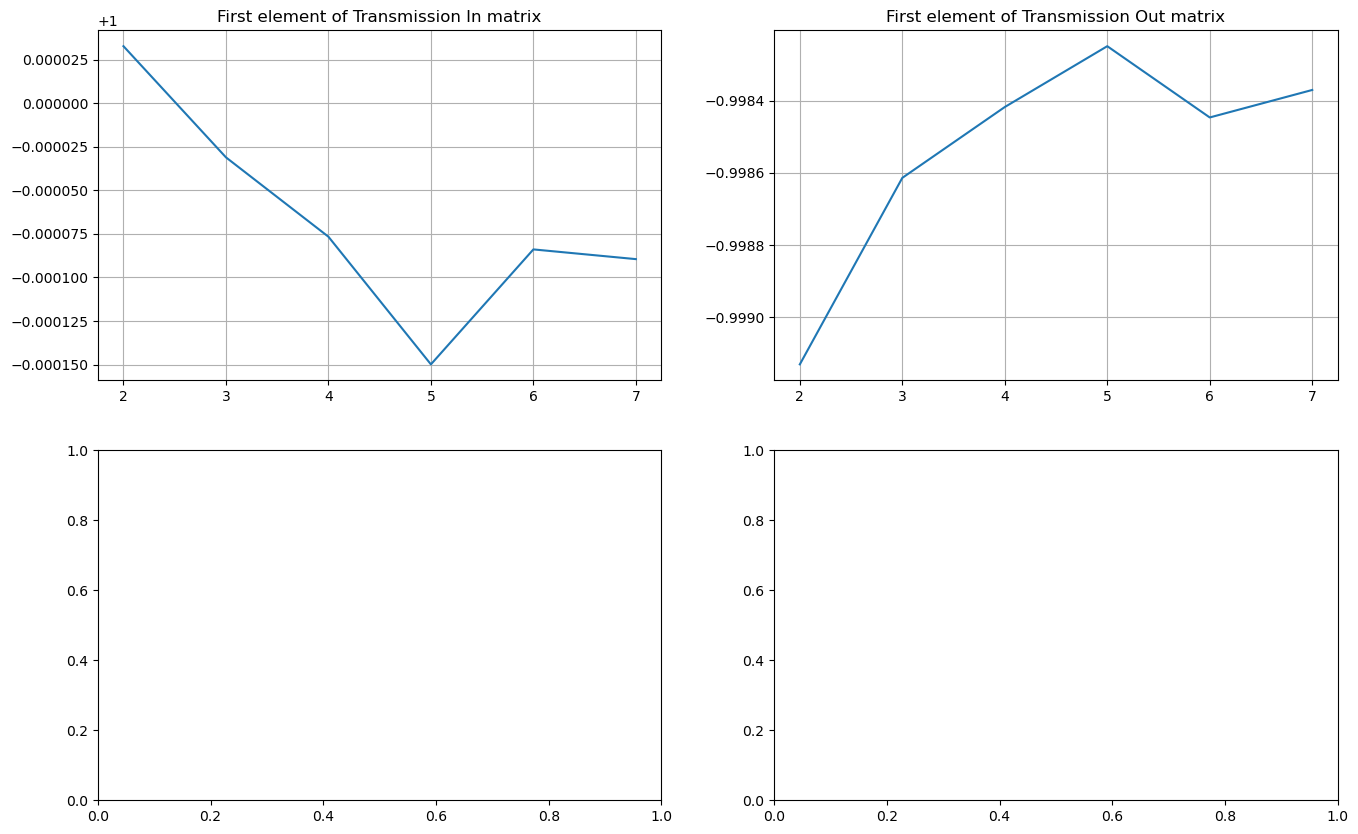

In [33]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sweepMatrix = ["Transmission In","Transmission Out"]
for j in range(3):    
    dataSet = hyb.getsweepresult("Mesh_sweep",sweepMatrix[j])
    subSet = dataSet['T']
    xSet = dataSet['Mesh accuracy']

    print(dataSet.keys())
    print(np.shape(subSet))

    TSet = []
    for i in range(len(subSet[0,:])):
        TSet.append(subSet[0,i])

    win = [int( j/2 ) , int( j%2 )] # Window plot indexes
    ax[win[0]][win[1]].plot(xSet[0,:],TSet)
    ax[win[0]][win[1]].grid(True)
    ax[win[0]][win[1]].set_title("First element of {} matrix".format(sweepMatrix[j]))

## Loadings

### Load Power field

dict_keys(['lambda', 'f', 'x', 'y', 'z', 'P', 'Lumerical_dataset'])
(283, 283, 1, 20, 3)


Text(0.5, 1.0, 'Eletric field distribution 1551.02nm')

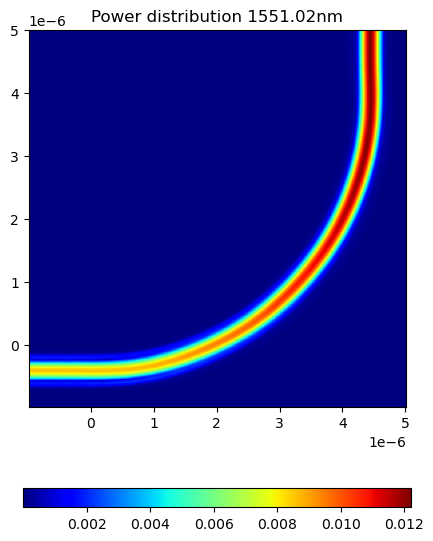

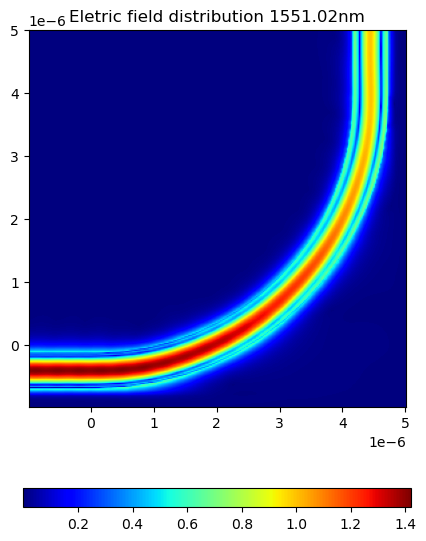

In [38]:
fIndex = 9  # Frequency index

# Power
P = hyb.getresult("monitor","P")
PwrArray = np.array(P['P'])
print(P.keys())
print(np.shape(PwrArray))

Px = PwrArray[:,:,0,fIndex,0]
Py = PwrArray[:,:,0,fIndex,1]
Pz = PwrArray[:,:,0,fIndex,2]

PAbs = np.sqrt(np.multiply(Px,Px) + np.multiply(Py,Py) + np.multiply(Py,Py))
Ax = ([ float(P['x'][0]) , float(P['x'][-1]) ])
Ay = ([ float(P['y'][0]) , float(P['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(5,7))
ax = plt.imshow(np.abs(np.transpose(PAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Power distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))


# Eletric field
E = hyb.getresult("monitor","E")
PwrArray = np.array(E['E'])

Ex = PwrArray[:,:,0,fIndex,0]
Ey = PwrArray[:,:,0,fIndex,1]
Ez = PwrArray[:,:,0,fIndex,2]

EAbs = np.sqrt(np.multiply(Ex,Ex) + np.multiply(Ey,Ey) + np.multiply(Ey,Ey))
Ax = ([ float(E['x'][0]) , float(E['x'][-1]) ])
Ay = ([ float(E['y'][0]) , float(E['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(5,7))
ax = plt.imshow(np.abs(np.transpose(EAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Eletric field distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))

### Load transmission

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


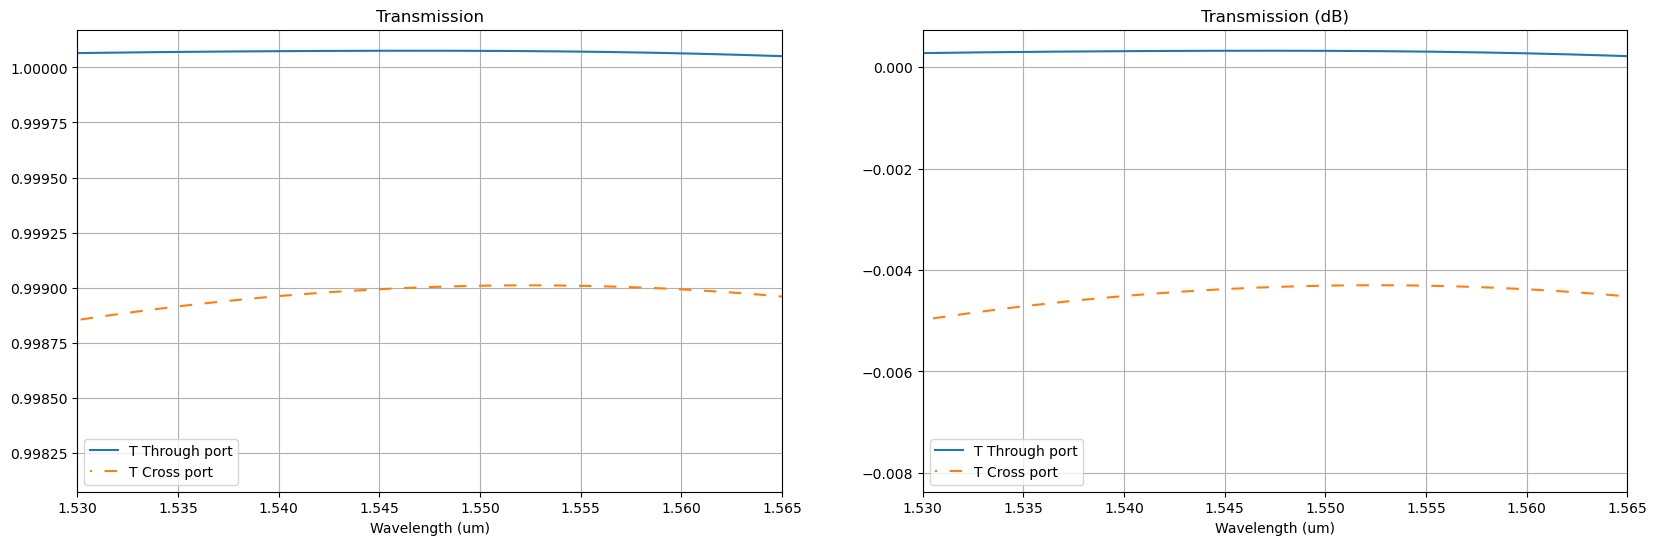

In [39]:
wavelim = [1.53, 1.565]

T3 = hyb.getresult("FDTD::ports::port 1","T")
T4 = hyb.getresult("FDTD::ports::port 2","T")

print(T3.keys())
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(T3['lambda']*1e6, T3['T'], label='T Through port')
ax[0].plot(T4['lambda']*1e6, -T4['T'], label='T Cross port',linestyle=(5, (6, 6)))
ax[0].set_title('Transmission')
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend()

ax[1].plot(T3['lambda']*1e6, 10*np.log10(T3['T']), label='T Through port')
ax[1].plot(T4['lambda']*1e6, 10*np.log10(-T4['T']), label='T Cross port',linestyle=(5, (6, 6)))
ax[1].set_title('Transmission (dB)')
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
ax[1].grid(True)
ax[1].legend()